In [1]:
%load_ext autoreload
%autoreload 2

### Comparison with random path

In [2]:
from src.models.markov_chains import *
from src.utils.HTMLParser import HTMLParser
from src.utils.helpers import *
from src.data.data_loader import *
import pandas as pd
import matplotlib.colors as mcolors
import plotly.express as px
import numpy as np
import config

parser = HTMLParser()
parser.load_pickle()

In [3]:
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat, df_article = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Pikachu', 'The Rock', 'Adolph Hitler', 'Test', 'Sportacus', 'Kashmir', 'Black ops 2', 'Rat', 'Christmas', 'English', 'Georgia', 'Netbook', 'Usa', 'The', 'Rss', 'Fats', 'Bogota', ' Zebra', 'Podcast', 'Great', 'Long peper', 'Western Australia', 'Mustard', 'Charlottes web', 'Macedonia'}
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Private Peaceful', 'Pikachu', 'Osteomalacia', 'Local community'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Wikipedia Text of the GNU Free Documentation License', 'Pikachu', 'Osteomalacia', 'Local community'}
Number of rows after filtering: 51196


In [4]:
df_paths = pd.concat([df_finished[['path', 'path_length']], df_unfinished[['path', 'path_length']]])

In [5]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
user_transitions = get_nth_transition_matrix(df_finished, df_article_names, 1)

print(f'Non-zero values of random transitions: {np.count_nonzero(markov_transitions)}')
print(f'Non-zero values of user transitions: {np.count_nonzero(user_transitions.to_numpy())}')

Non-zero values of random transitions: 119855
Non-zero values of user transitions: 25151


<div class="alert alert-block alert-info">

The transition matrix's $P$ left eigenvector with eigenvalue 1 (i.e. $x$ such that $xP=x$) is called the steady-state of the system. Let's call the normalised vector $x = (x_1, x_2, \dots, x_N)$, where the sum of all $x_i$ is 1. After $\infty$ iterations, starting from whatever article, the probability distribution of the end article is given by $x$. 

**Example**: For 3 articles, let's say that we have $x=(0.2, 0.3, 0.5)$. Then, when starting from any of the articles and taking infinitely many steps, there is probability 0.2 to be in article 1, probability 0.3 to be in article 2 and probability 0.5 to be in article 3.

</div>

In [6]:
ss = compute_steady_state(markov_transitions, df_article_names)

In [7]:
ss.sort_values(by='steady_state_proportion', ascending=False).head(20)

,articles,steady_state_proportion
4280,United States,0.013515
1562,France,0.010126
4276,United Kingdom,0.009922
1427,Europe,0.007502
1687,Germany,0.007472
1383,English language,0.006910
1433,European Union,0.006109
4523,World War II,0.005818
3554,Russia,0.005677
1379,England,0.005490


In [8]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=True)
ssb = compute_steady_state(markov_transitions, df_article_names, backclicks=True)

In [9]:
ssb.sort_values(by='steady_state_proportion', ascending=False).head(20)

,articles,steady_state_proportion
0,<,0.022395
4281,United States,0.013123
1563,France,0.009682
4277,United Kingdom,0.009540
1428,Europe,0.007221
1688,Germany,0.007137
1384,English language,0.006593
1434,European Union,0.005803
4524,World War II,0.005620
3555,Russia,0.005439


<div class="alert alert-block alert-success">
There is indeed a vector with eigenvalue one, so there is a steady state in the system. To find the probabilities to be in a certain article in the steady state, we can look at the normalised values of the eigenvector. We see that United States is the most likely article to be in, followed mainly by a bunch of other countries.
</div>

<div class="alert alert-block alert-info">

#### Compare user vs random

Let's start in any article $i$ and take $l$ steps in the network, which leads to article $j$. The probability of this happening by chance in the network is simply $P_{ij}(l)=A^l_{ij}$. To get probabilities of transitions for every pair of articles and path length $l$, we only need to take the $l$-th power of the transition matrix! This effectively characterises the bias of the network itself: if users pass by an article A very often BUT that only by chance you end up on the same article often too, we cannot conclude that the user made that choice. 

To characterise the user choices, we simply take the paths they created by playing. We can then similarly create a transition matrix based on observed data: just take the aggregated count of all the transitions from all starting articles. For instance, from article $i$ we count 2 transitions to article $j_1$, 3 to $j_2$ and none to $j_3$. The normalised transition probabilities for article $i$ are then $(0.4, 0.6, 0)$. 

The difference in transition probabilities $\Delta P=(0.4, 0.6, 0) - (0.2, 0.3, 0.5) = (0.2, 0.3, -0.5) \in [-1, 1]^3$ then gives an idea of how likely it is that a user purposedly made a choice and not only ended in an article by accident. A highly positive value means that even though the transition is very unlikely in the network, the user made that choice. A larger negative value means that a user took a path that is rather unlikely under the random walk assumption. The Markov Chain allows to filter out the network bias in the user decisions.

<b>Note:</b> Maybe look into odds instead of probabilities to be more rigorous? https://stats.stackexchange.com/questions/22796/compare-the-difference-of-two-probabilities-or-a-ratio-of-probabilities

</div>

In [35]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False, )
user_transitions = get_nth_transition_matrix(df_finished, df_article_names, 1)

In [36]:
markov_transitions.max()

1.0

In [37]:
diff = user_transitions-markov_transitions
mean_diff_indegree = diff.sum(axis=0).sort_values(ascending=False)
mean_diff_indegree

article
United States                219.681123
Europe                       100.233262
England                       95.131996
United Kingdom                69.586810
World War II                  40.748234
                                ...    
Animal                       -10.015920
Carolus Linnaeus             -10.290777
Binomial nomenclature        -18.524412
Chordate                     -19.782002
Scientific classification    -21.930998
Length: 4584, dtype: float64

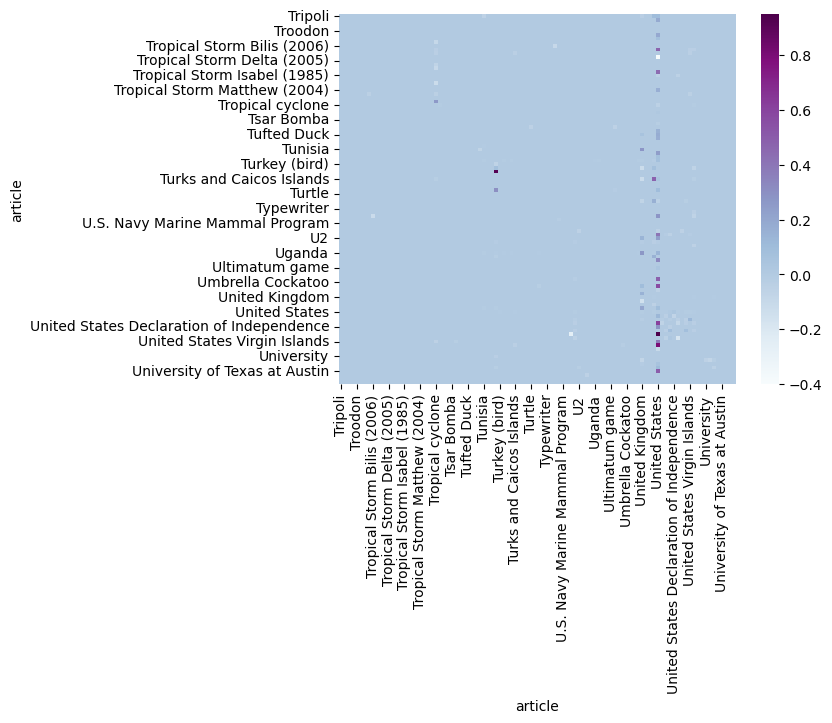

In [38]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(diff.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

In [39]:
KL = np.where((user_transitions > 0) & (markov_transitions > 0), user_transitions * np.log(user_transitions / markov_transitions), 0)
KL_df = pd.DataFrame(KL, columns=user_transitions.columns, index=user_transitions.index)
mean_KL = KL_df.mean(axis=0).sort_values(ascending=False)
mean_KL

c:\Users\yanni\.conda\envs\ada_project\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning:

divide by zero encountered in log



article
United States           0.126691
Europe                  0.060306
England                 0.055590
United Kingdom          0.044209
World War II            0.027677
                          ...   
GNOME                  -0.000058
Abhidhamma Pitaka      -0.000059
The Supremes           -0.000065
Wikimedia Foundation   -0.000072
Action potential       -0.000076
Length: 4584, dtype: float64

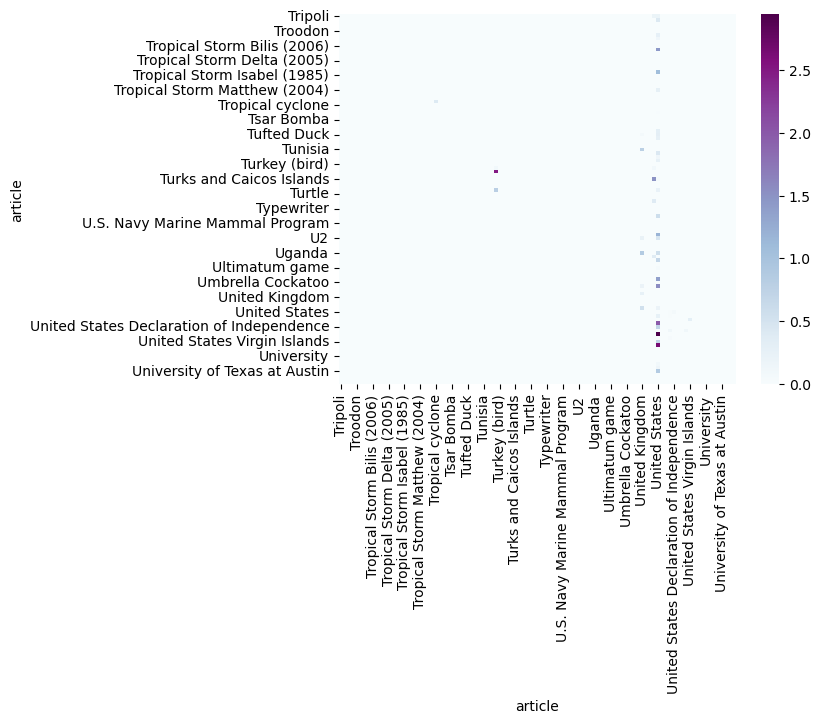

In [40]:
sn.heatmap(KL_df.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

<div class="alert alert-block alert-success">

For the first transition, much more users go to United States or Europe than only following random transitions would.

<b>Notes:</b> 
- Values close to 0 means it is close to random behaviour. Values that are closer to -1 or 1 are the special behaviour, either clicking much more or much less on certain articles than random would predict.
- How could we remove the link position bias? Maybe check if certain links are on the top/bottom of the page and give more or less importance accordingly?
- Does adding backclicks as in the function above make sense?
</div>

## How does user's deviation from random path evolve during games ?


<div class="alert alert-block alert-success">

We can look at the difference between user games and random games at different steps of the game. This highlights the evolution of which articles palyers **voluntarily chose** to visit at different stages of the game. 
</div>

In [18]:
%%capture
mean_KL_step = get_step_divergences(df_article_names, parser, df_paths, backclicks=False)

In [19]:
PALETTE_ARTICLE_DICT_COLORS = {}
for _, row in df_categories.iterrows():
    article = row['article']
    category = row['level_1']
    PALETTE_ARTICLE_DICT_COLORS[article] = config.PALETTE_CATEGORY_DICT.get(category, '#808080')

PALETTE_ARTICLE_DICT_COLORS['<'] = '#000000'

main_mean_div = mean_KL_step.iloc[:30]
fig_art = plot_article_step_divergence(main_mean_div, PALETTE_ARTICLE_DICT_COLORS)
fig_art.show()

### What about the evolution of categories ?

In [20]:
%%capture

KL_cat_df = get_step_divergences(df_article_names, parser, df_paths, df_categories=df_categories, backclicks=False)

In [21]:
backclick_palette = config.PALETTE_CATEGORY_DICT_COLORS
backclick_palette['<'] = '#000000'
fig_cat = plot_category_step_divergence(KL_cat_df, backclick_palette)
fig_cat.show()

<div class="alert alert-block alert-success">
The Countries and Geography categories have similar behaviors, having extreme values, both strongly positive values for the first transition (~200 and 70 respectively), and strongly negative values in later steps (between -500 and -1000 and between -350 and -550 respectively).

- The stronly positive values for the first transition shows strong evidence that the first click of players are voluntarily directed towards Countries and Geography articles.

- The strong negative values for following steps shows strong evidence that folowing the first clicks, players voluntarily direct their click towards other categories.  

Further study of the evolution of country and geography articles is needed to explore where those strong values come from.

Let's look at articles of the Countries category more specifically:
</div>

<div class="alert alert-block alert-success">
Interestingly, no strongly negative values appear in later steps. This indicates that the strong negative values in the category plot is likely due to the accumulation of many small negative deviation from the random path. 

Lets verify this assimption by grouping articles that stay close to the random path as 'Others' article, and plotting their mean, and the value of their sum. 
</div>

<div class="alert alert-block alert-success">
A great majority of countries articles are clicked close to randomly (the difference between player path and random path is close to 0), but they are so numerous that they cumulate to be very significant in the country category.

These articles being so influent in the category stats and being close to random, we could make the choice to ingore them by :
finding a way for them not to influence so much the category: by removing them? by expressing them under 'Other_mean'? how to justify this choice? 
</div>

### Categories normalised by transition probabilities

In [23]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False, normalise=False)

In [24]:
from collections import Counter
from src.utils.helpers import map_path_to_categories

article_to_category = dict(zip(df_categories['article'], df_categories['level_1']))
mapped_categories = map_path_to_categories(df_article_names, article_to_category)
transitions_per_category = pd.DataFrame({'category': mapped_categories, 'transition': markov_transitions.sum(axis=1)})
transitions_per_category=transitions_per_category.groupby('category', as_index=False).sum()
category_counts = Counter(mapped_categories)
category_counts_df = pd.DataFrame(category_counts.items(), columns=['category', 'count'])

result = pd.merge(category_counts_df , transitions_per_category, on='category')
result['ratio'] =  result['transition'] / result['count']
result=result.sort_values(by='ratio')

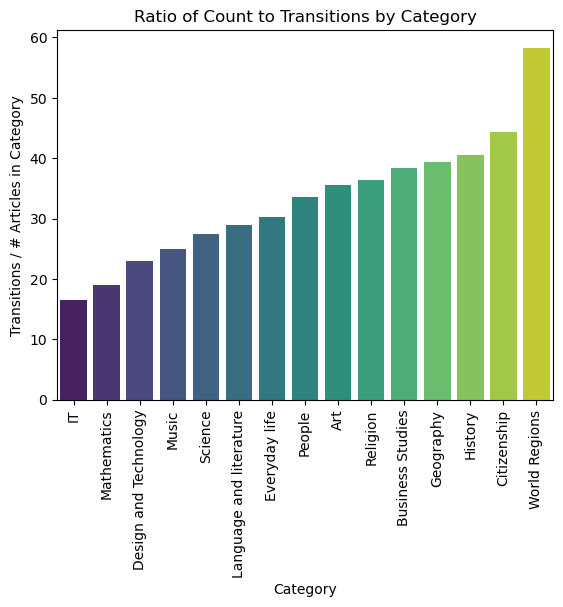

In [25]:
#TODO: adapt plot to colors and categories chosen

sn.barplot(data=result, x='category', y='ratio', hue='category', legend=None, palette='viridis')

# Customize the plot
plt.xlabel('Category')
plt.ylabel('Transitions / # Articles in Category')
plt.title('Ratio of Count to Transitions by Category')
plt.xticks(rotation=90) 
plt.show()